# PyTorch🔥Deep Convolutional MNIST GAN

Subject: Building a GAN (Generative Adversarial Network) with PyTorch to generate hand-written digits from noise, trained from MNIS dataset. Use <b>CNN Architecture</b> (cf. other notebook).

Data: MNIST (handwritten digits) via torchvision

Procedure:
- Previewing images from dataset with pyplot's imshow()
- Generator network with torch.nn.module, torch.nn.Sequential, torch.nn.BatchNorm2d, torch.nn.Upsample, torch.nn.Conv2d, torch.nn.LeakyReLU, and torch.nn.Tanh
- Discriminator with torch.nn.module, torch.nn.Sequential, torch.nn.Conv2d, and torch.nn.LeakyReLU, torch.nn.Dropout2d, torch.nn.Linear, and torch.nn.Sigmoid
- Visualizing generator and discriminator with torchviz' make_dot()
- Training with nn.BCEWithLogitsLoss as loss and two torch.optim.Adam optimizers (one for both generator and discriminator)
- Previewing generated digits with imshow() after each n training steps
- Visualization Loss for generator and discriminator with pyplot
- Display development of generated images during training as image show with matplotlib.animation.ArtistAnimation
- Interesting results

Others:
- CUDA support

Sources used:
- todo

## Bootstrap and Imports

In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

if IN_COLAB := 'google.colab' in str(get_ipython()):
  NUM_EPOCHS = 100
  !pip install torchviz

else:
  NUM_EPOCHS = 2

Running on cuda
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=f3204c53ba080fac412035ccbee8fa087f4165bbcd4953df1e05df4cd8c6ed95
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
from __future__ import print_function
import random
from tqdm.auto import tqdm
import numpy as np
from collections.abc import Callable

from IPython.display import HTML, Image

import time
import matplotlib.animation as animation
import matplotlib.pyplot as plt
#%matplotlib inline

import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision import utils
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torchviz import make_dot

my_seed = 123
random.seed(my_seed)
torch.manual_seed(my_seed);

In [3]:
def get_describe_only_once() -> Callable:
    already_described = set()

    def _describe_only_once(tensor: torch.Tensor, name: str):
        if name in already_described:
            return
        already_described.add(name)
        if hasattr(tensor, 'shape'):
            print(f"{name} is a {type(tensor)} of size {tensor.shape}.")
        else:
            print(f"{name} is a {type(tensor)} with content {tensor}.")
    return _describe_only_once

describe_only_once = get_describe_only_once()

## Constants

In [4]:
BATCH_SIZE = 128
Z_DIM = 64  # dimension of the noise vector
CHANNELS = 1

# 28x28 is the original size; visualization works best with 28x28
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28

LEARNING_RATE = 0.0001

IMAGE_SIZE = (1, 28, 28)

## Dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH], antialias=True)  # only required if != 28 x 28
])

# download and save mnist at ./data
data_train = datasets.MNIST('./data', download=True, train=True, transform=transform)  # data_train.data: <class 'torch.Tensor'> of size torch.Size([60000, 28, 28]).
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 464938284.14it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112999714.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155766828.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6369284.11it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



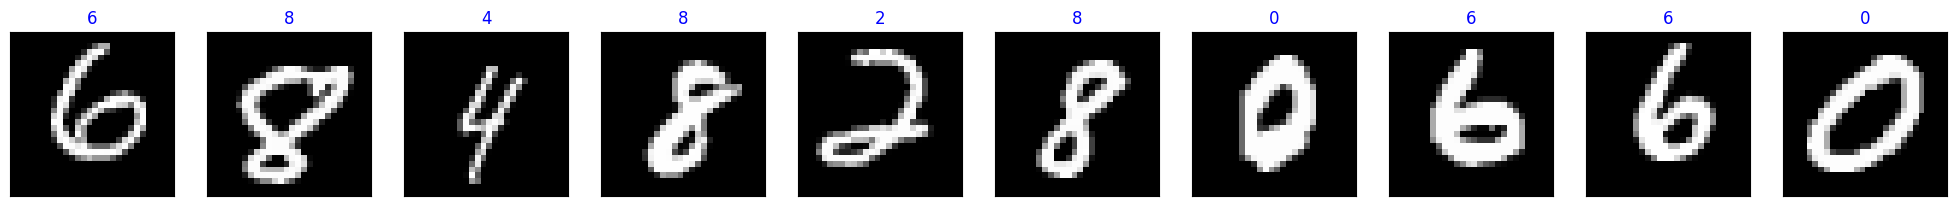

In [6]:
# print some random mnist images
classes = ['0','1','2','3','4','5','6','7','8','9']

dataiter = iter(train_loader)
images, labels = next(dataiter)            # images:[128, 1, 28, 28], labels: [128]
                                           #

fig = plt.figure(figsize=(25, 10))  # (width, height) in inches

for i in range(10):
    ax = fig.add_subplot(1,         # nrows
                         10,        # ncols
                         i+1,       # index (1-based)
                         xticks=[],
                         yticks=[])
    image = images[i]                               # [1, 28, 28]
    # image_numpy_squeezed = image.numpy().squeeze()  # <class 'numpy.ndarray'> of size (28, 28)  # conversion to ndarry not required(anymore).
    label = labels[i]                               # []
    label_item = label.item()                       # <class 'int'> with content e.g. 3
    ax.imshow(X=image.squeeze(),
              cmap='gray')
    ax.set_title(f"{classes[label_item]}", color=("blue"))

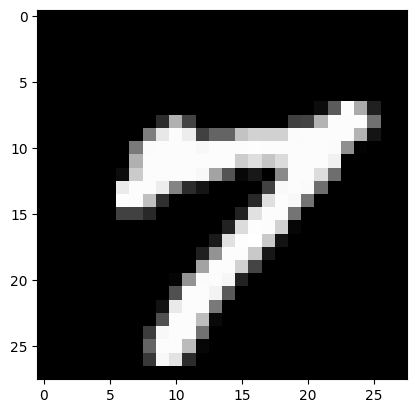

In [7]:
# plot an individual image
image_flat = random.choice(images).squeeze() #  <class 'torch.Tensor'> of size torch.Size([28, 28]).
plt.imshow(image_flat, cmap='gray')  # <class 'torch.Tensor'> of size torch.Size([1, 28, 28]).

## Generator
Generator training requires tighter integration between the generator and the discriminator than discriminator training requires. The portion of the GAN that trains the generator includes:
- random input
- generator network, which transforms the random input into a data instance
- discriminator network, which classifies the generated data
- discriminator output
- generator loss, which penalizes the generator for failing to fool the discriminatorinator

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, img_dim=IMAGE_HEIGHT * IMAGE_WIDTH, hidden_dim=128):
        super(Generator, self).__init__()

        self.init_size = IMAGE_HEIGHT // 4  # // not sure about this one
        self.l1 = nn.Sequential(nn.Linear(Z_DIM, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, CHANNELS, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [9]:
# generate random noise as generator input
def get_generator_noise(n_sample: int, z_dim: int, device=DEVICE):
  my_noise = torch.randn(n_sample, z_dim, device=device)
  return my_noise


some_noise = get_generator_noise(n_sample=BATCH_SIZE,  # [128, 64]
                                 z_dim=64)

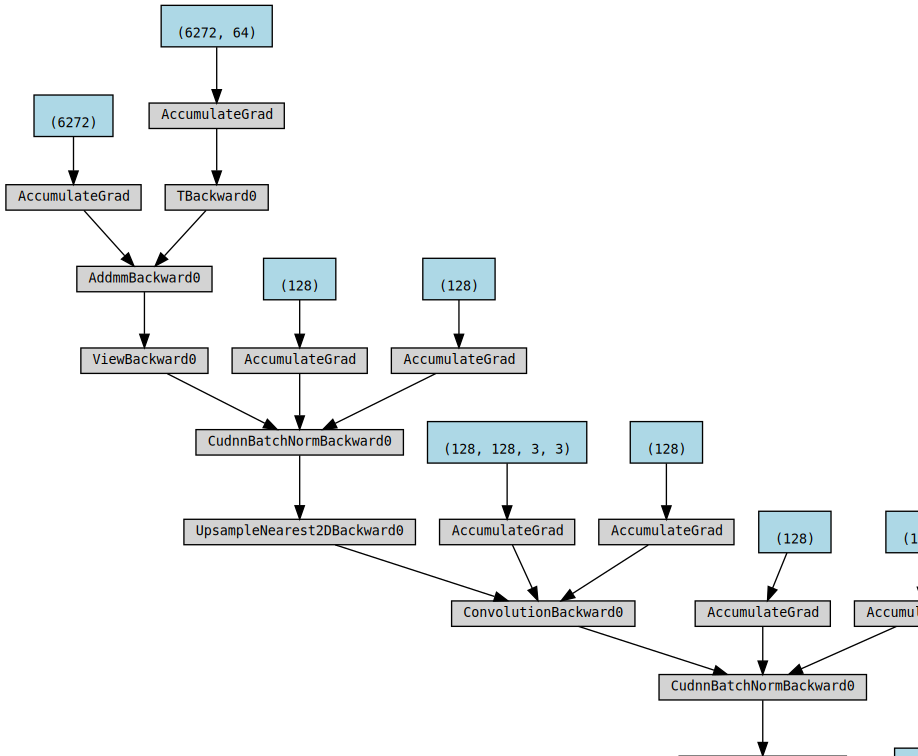

In [10]:
# visualize the Generator
g_temp = Generator(z_dim=Z_DIM).to(DEVICE)
# to visualize with torchviz, we need a dummy input that can pass through the model's forward() method.
generator_output = g_temp(some_noise)  # [128, 1, 28, 28]
make_dot(generator_output)

## Discriminator
The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator. It could use any network architecture appropriate to the type of data it's classifying.

The discriminator's training data comes from two sources:

- Real data instances, such as real pictures of people. The discriminator uses these instances as positive examples during training.
- Fake data instances created by the generator. The discriminator uses these instances as negative examples during training.

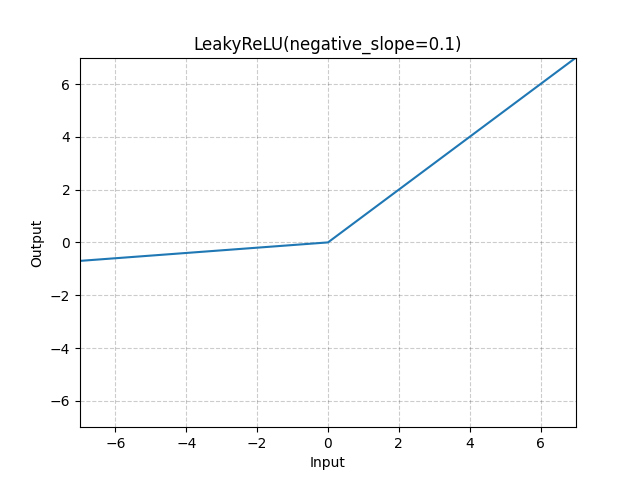

In [11]:
Image("https://pytorch.org/docs/stable/_images/LeakyReLU.png")

In [12]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=IMAGE_HEIGHT * IMAGE_WIDTH, hidden_dim=128):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(CHANNELS, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        # todo ds_size = IMAGE_HEIGHT // 2 ** 4
        ds_size = 32 // 2 ** 4  # not sure about this one
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1),
                                       nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

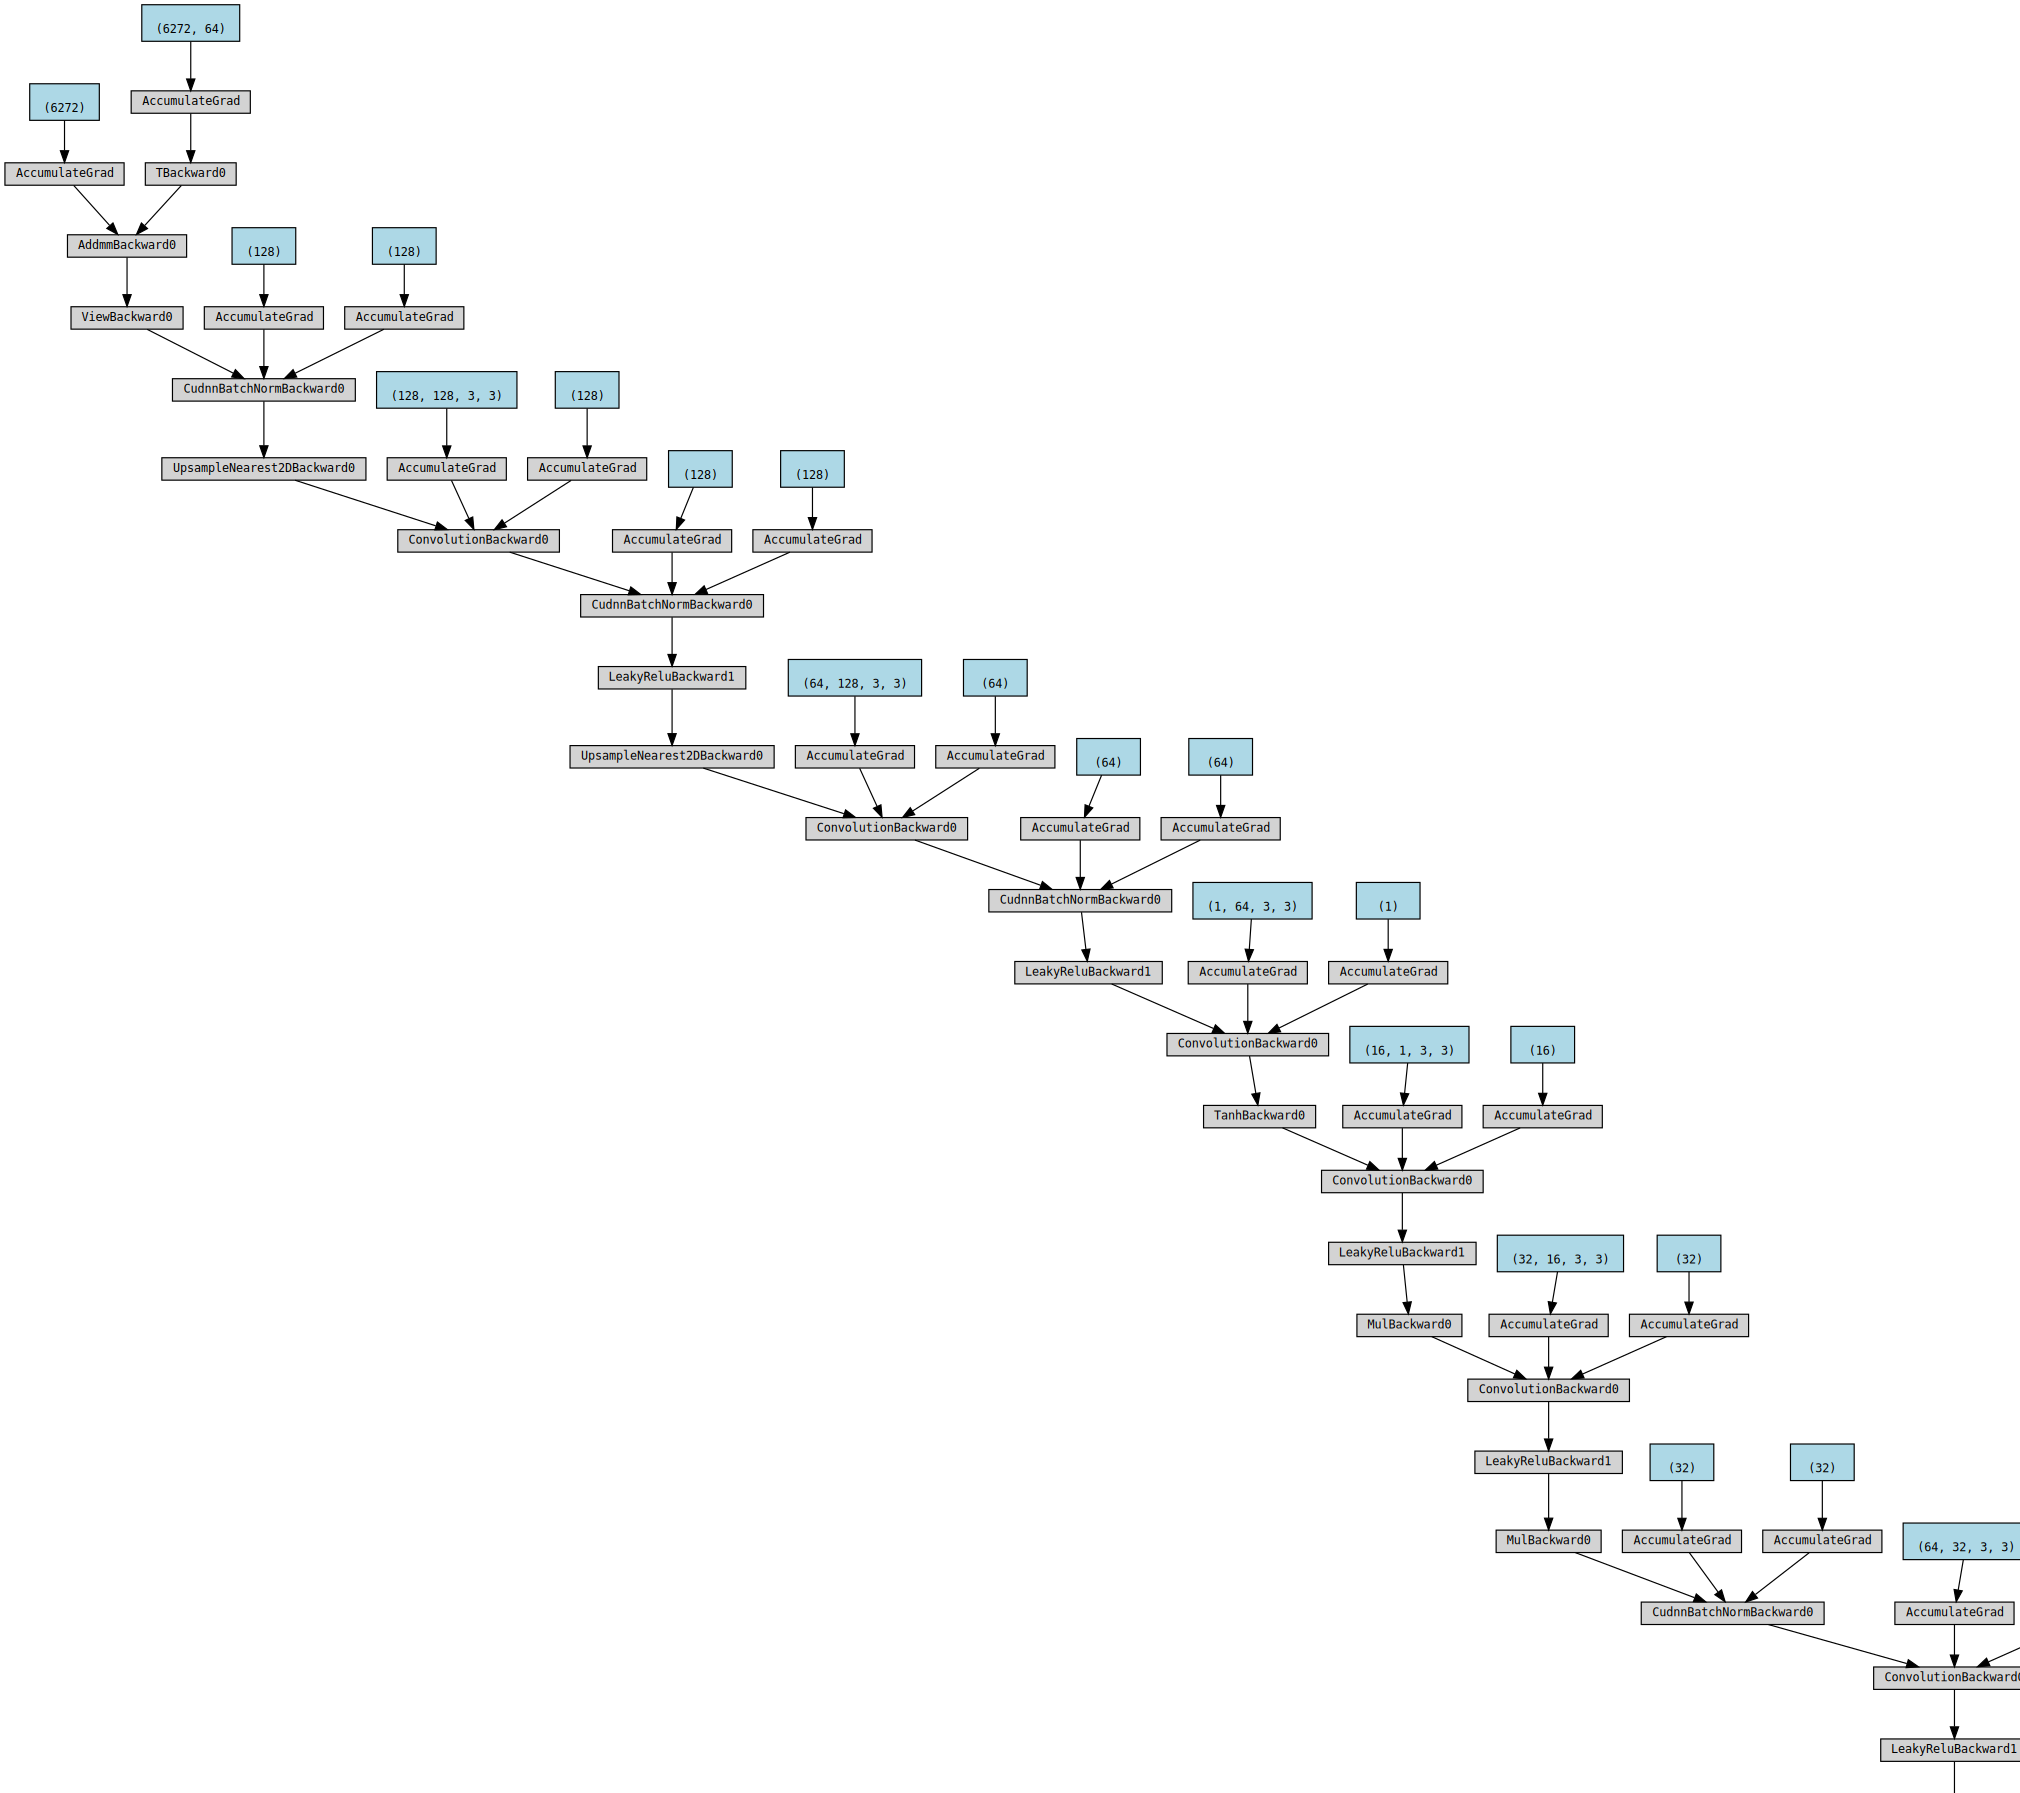

In [13]:
# visualize the Discriminator
d_temp = Discriminator().to(DEVICE)
# to visualize with torchviz, we use the dummy Generator output as dummy input.
discriminator_output = d_temp(generator_output)  # [128, 1]
make_dot(discriminator_output)

## Training
Because a GAN contains two separately trained networks, its training algorithm must address two complications:

- GANs must juggle two different kinds of training (generator and discriminator
-
GAN convergence is hard to identify.

In [14]:
criterion = nn.BCEWithLogitsLoss()

In [15]:
def get_generator_loss(discriminator: Discriminator,
                       criterion: _Loss,
                       fake_images: torch.Tensor):  # [128, 28, 28]
    # add one dimension to fake_images
    fake_images_ = fake_images.view(-1, *(1, IMAGE_HEIGHT, IMAGE_WIDTH))  # [128, 1, 28, 28]
    discriminator_predictions = discriminator(fake_images_) # [128, 1], e.g. tensor([[0.4881], [0.4923], ...])

    # fake labels are real for generator cost
    labels_real = torch.ones_like(discriminator_predictions)  # [128, 1], tensor([[1.], [1.], ...])
    generator_loss = criterion(discriminator_predictions, labels_real)  # [], e.g. tensor(0.7110, grad_fn=<BinaryCrossEntropyBackward0>)

    return generator_loss

In [16]:
def get_discriminator_loss(discriminator: Discriminator,
                           criterion: _Loss,
                           fake_images: torch.Tensor,  # [128, 28, 28]
                           real_images_flat: torch.Tensor): # [128, 784]

    # we need another layer for fake_images
    fake_images_ = fake_images.view(-1, *(1, IMAGE_HEIGHT, IMAGE_WIDTH))  # [128, 1, 28, 28]
    discriminator_output_fake = discriminator(fake_images_.detach())  # [128, 1]
    labels_fake = torch.zeros_like(discriminator_output_fake)  # [128, 1]
    discriminator_loss_fake = criterion(discriminator_output_fake, labels_fake)  # [], e.g. tensor(0.6751, grad_fn=<BinaryCrossEntropyBackward0>)

    # for real images we need another 2 layers
    real_images_ = real_images_flat.view(-1, *(1, IMAGE_HEIGHT, IMAGE_WIDTH))  # [128, 1, 28, 28]
    discriminator_output_real = discriminator(real_images_)  # [128, 1], e.g. tensor([[0.4927], [0.4889], ...])
    labels_real = torch.ones_like(discriminator_output_real)  # [128, 1]
    discriminator_loss_real = criterion(discriminator_output_real, labels_real)  # [], e.g. tensor(0.7091, grad_fn=<BinaryCrossEntropyBackward0>)

    discriminator_loss = (discriminator_loss_fake + discriminator_loss_real) / 2  # [], e.g. tensor(0.6921, grad_fn=<DivBackward0>)
    return discriminator_loss

In [17]:
# Generator
generator = Generator(Z_DIM).to(DEVICE)
gen_optimizer = torch.optim.Adam(generator.parameters(),
                                 lr=LEARNING_RATE)

# Discriminator
discriminator = Discriminator().to(DEVICE)
disc_optimizer = torch.optim.Adam(discriminator.parameters(),
                                  lr=LEARNING_RATE)

In [18]:
# Show Images Function
def show_tensor_images(real_images_flattened, #
                       fake_images_flat,   #
                       num_images=25,
                       size=(1, 28, 28)):
  plt.figure(figsize=(15,15))
  real_images_unflattened = real_images_flattened.detach().cpu().view(-1, *size)  #
  image_grid_real = make_grid(real_images_unflattened[:num_images], nrow=5, normalize=True, padding=2)  #
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(image_grid_real.permute(1, 2, 0).squeeze())

  fake_images_unflattened = fake_images_flat.detach().cpu().view(-1, *size)  #
  image_grid_fake = make_grid(fake_images_unflattened[:num_images], nrow=5, normalize=True, padding=2)  #
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(image_grid_fake.permute(1, 2, 0).squeeze())
  plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 0/2] | [Step: 0/938] Generator Loss: 0.003696016501635313, Discriminator Loss: 0.00565885566174984


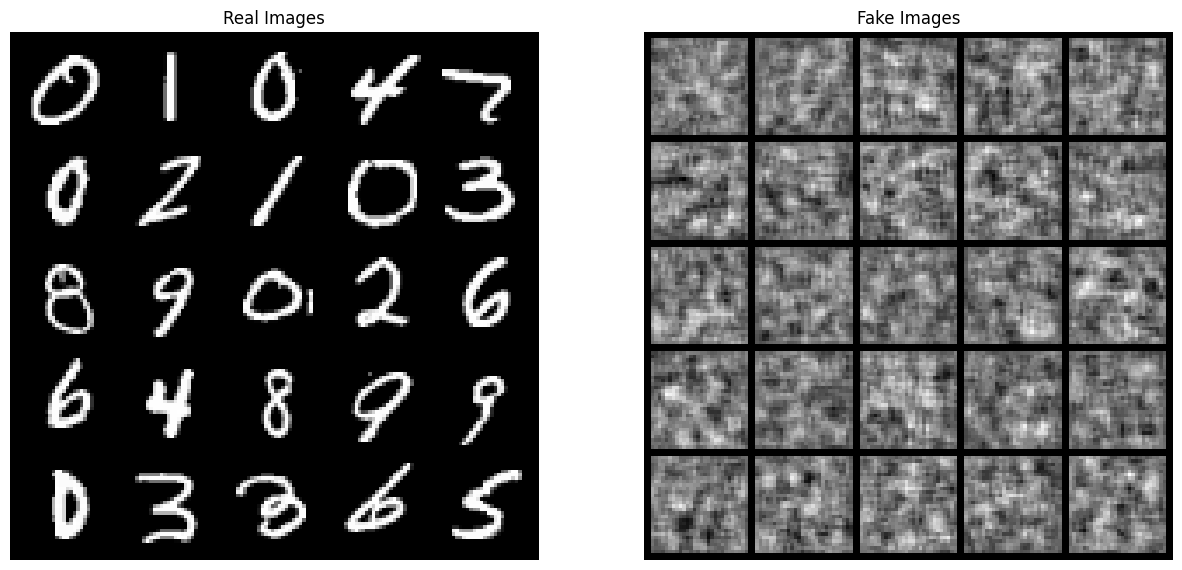

[Epoch: 0/2] | [Step: 100/938] Generator Loss: 0.373156686546281, Discriminator Loss: 0.5649199560284615
[Epoch: 0/2] | [Step: 200/938] Generator Loss: 0.3911682509351522, Discriminator Loss: 0.5579156866297126
[Epoch: 0/2] | [Step: 300/938] Generator Loss: 0.434310135897249, Discriminator Loss: 0.5500700576230884


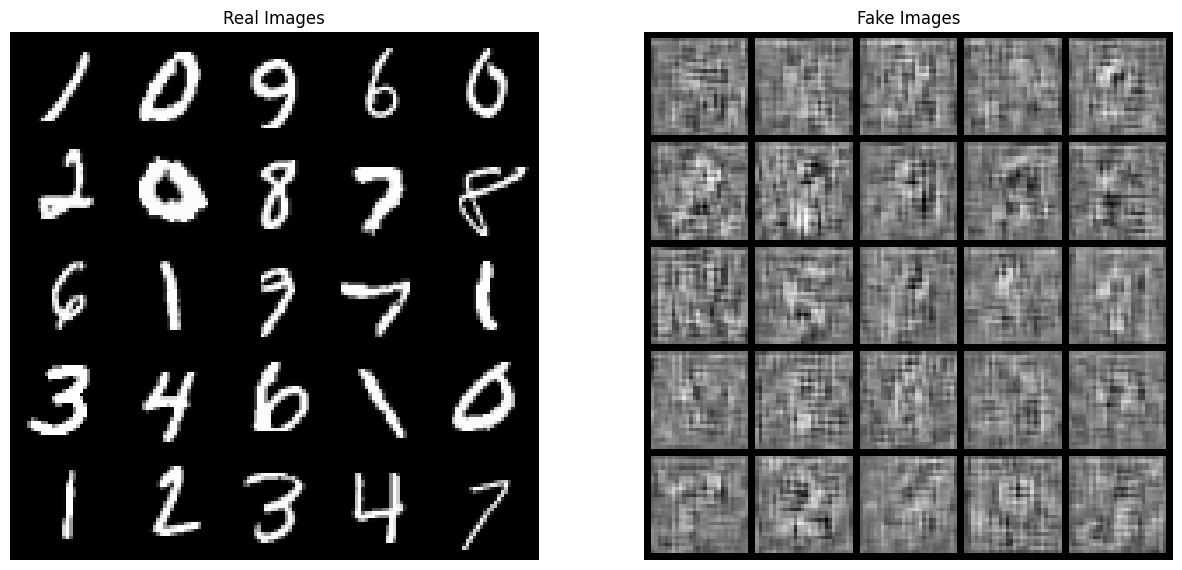

[Epoch: 0/2] | [Step: 400/938] Generator Loss: 0.4892309154383838, Discriminator Loss: 0.5433093318715692


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 1/2] | [Step: 500/938] Generator Loss: 0.5033280565403402, Discriminator Loss: 0.5427480743577082
[Epoch: 1/2] | [Step: 600/938] Generator Loss: 0.4941661427728832, Discriminator Loss: 0.5402439842000604


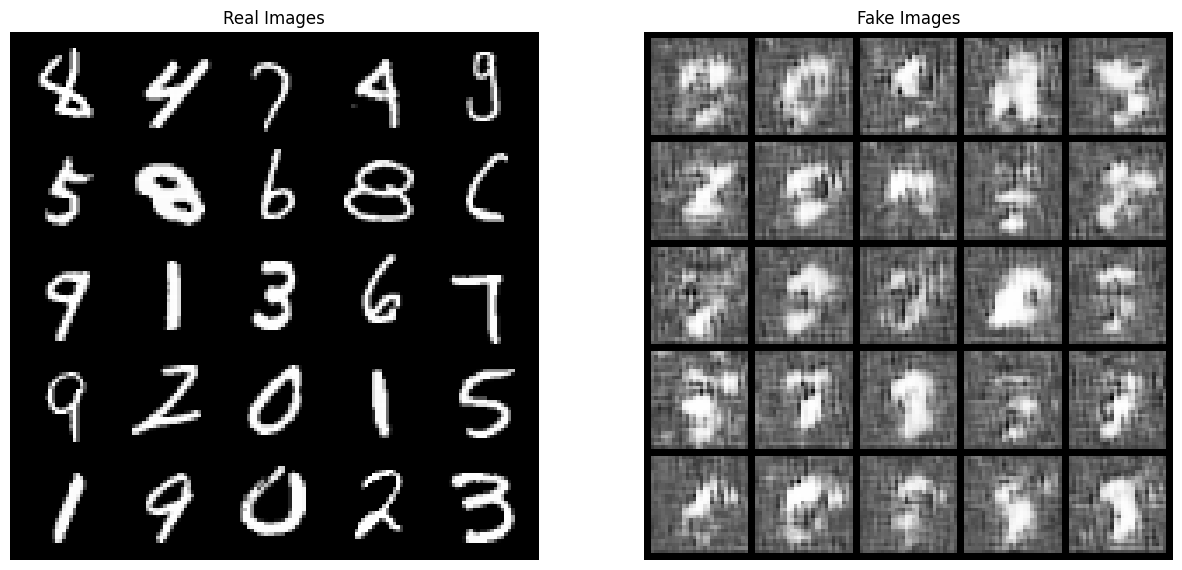

[Epoch: 1/2] | [Step: 700/938] Generator Loss: 0.5130139938555658, Discriminator Loss: 0.5415918887592852
[Epoch: 1/2] | [Step: 800/938] Generator Loss: 0.5197138907387853, Discriminator Loss: 0.5421312446705997
[Epoch: 1/2] | [Step: 900/938] Generator Loss: 0.5293028564192355, Discriminator Loss: 0.5411388808861375


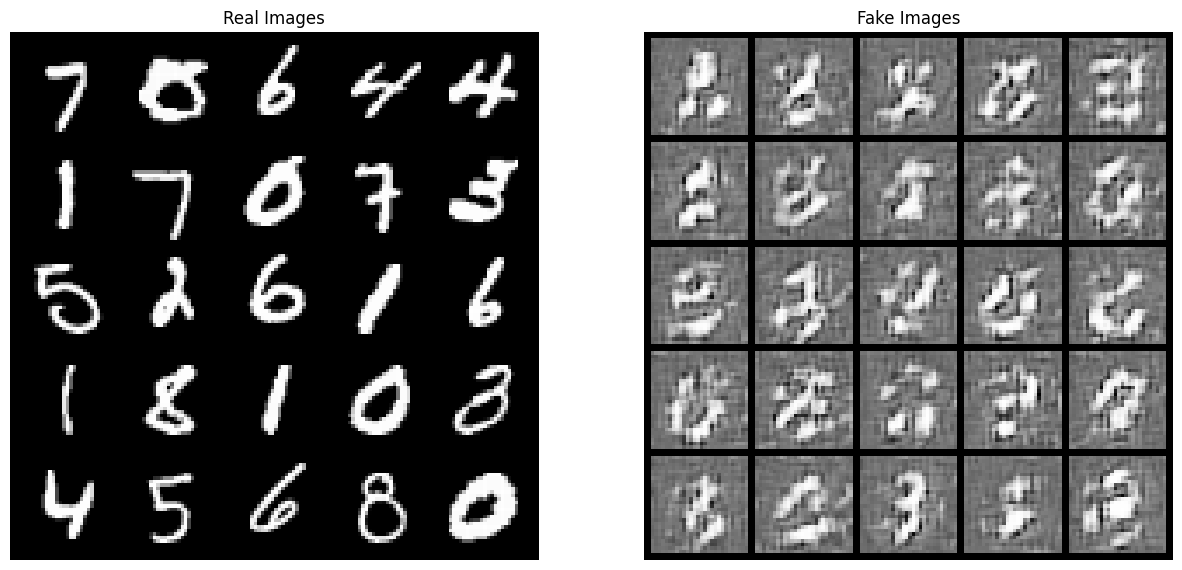

[Epoch: 1/2] | [Step: 937/938] Generator Loss: 0.19628523740296563, Discriminator Loss: 0.20208549747864404


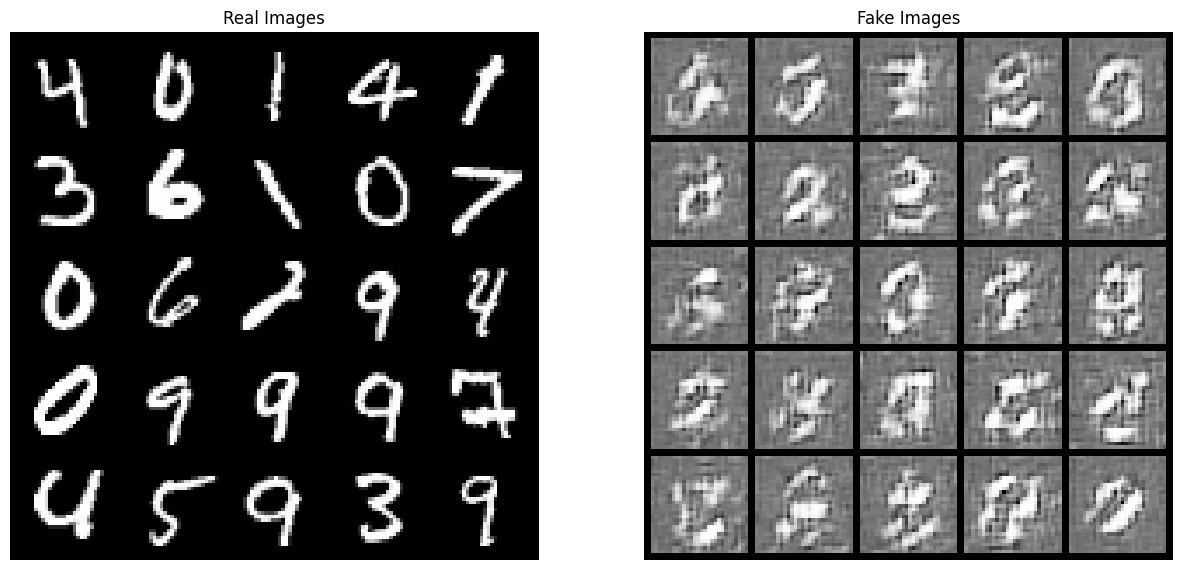

time for train:  0.01092830883132087 hours


In [19]:
# Training Loop
DISPLAY_STEP = 100
TOTAL_STEPS = NUM_EPOCHS*len(train_loader)

image_show = []

# for visualizing development after training
generator_losses = []
discriminator_losses = []
current_step = 0

mean_generator_loss = 0
mean_discriminator_loss = 0
start_time = time.time()

epoch: int
for epoch in range(NUM_EPOCHS):

  for real_images, _ in tqdm(train_loader):  # real_images: [128, 1, 28, 28]

    # batch size might be different than BATCH_SIZE in the last of an epoch's batches
    current_batch_size = len(real_images)

    # create new tensor with the same data but of a different shape (cf. np.squeeze())
    real_images_flat = real_images.view(current_batch_size, -1).to(DEVICE)  # [128, 784]

    # generated fake images
    noise = get_generator_noise(n_sample=current_batch_size,
                                z_dim=Z_DIM,
                                device=DEVICE)  # [128, 64]
    fake_images = generator(noise)  # [128, 1, 28, 28]

    #-----------
    # train discriminator
    #-----------
    # set the gradients of all optimized torch.Tensors to zero.
    disc_optimizer.zero_grad()
    discriminator_loss = get_discriminator_loss(
                                       discriminator=discriminator,
                                       criterion=criterion,
                                       fake_images=fake_images,
                                       real_images_flat=real_images_flat)  # []
    # compute the gradient of current tensor w.r.t. graph leaves.
    discriminator_loss.backward()
    # perform a single optimization step (parameter update).
    disc_optimizer.step()

    #-----------
    # train generator
    #-----------
    # set the gradients of all optimized torch.Tensors to zero.
    gen_optimizer.zero_grad()
    generator_loss = get_generator_loss(
                                  discriminator=discriminator,
                                  criterion=criterion,
                                  fake_images=fake_images)  # []
    # compute the gradient of current tensor w.r.t. graph leaves.
    generator_loss.backward()
    # perform a single optimization step (parameter update).
    gen_optimizer.step()

    mean_discriminator_loss += discriminator_loss.item() / current_batch_size  # <class 'float'> with content 0.001509111374616623.
    mean_generator_loss += generator_loss.item() / current_batch_size  # <class 'float'> with content 0.019790537655353546.

    generator_losses.append(mean_generator_loss)
    discriminator_losses.append(mean_discriminator_loss)

    if (current_step % DISPLAY_STEP == 0) or (current_step == TOTAL_STEPS - 1):

      # remember fake images for the image show below
      image_show.append(make_grid(fake_images.detach().cpu().view(-1, *IMAGE_SIZE)[:36], nrow=6, normalize=True, padding=2))

      print(f"[Epoch: {epoch}/{NUM_EPOCHS}] | [Step: {current_step}/{TOTAL_STEPS}]",
            f"Generator Loss: {mean_generator_loss}, "
            f"Discriminator Loss: {mean_discriminator_loss}")

      mean_discriminator_loss = 0
      mean_generator_loss = 0

      # every n steps, live display 25 real and 25 generated images
      if (current_step % (DISPLAY_STEP * 3) == 0) or (current_step == TOTAL_STEPS - 1):
          show_tensor_images(real_images_flattened=real_images_flat,
                             fake_images_flat=fake_images)

    current_step += 1


end = time.time() - start_time
print('time for train: ', end/3600 , 'hours')

## Visualization

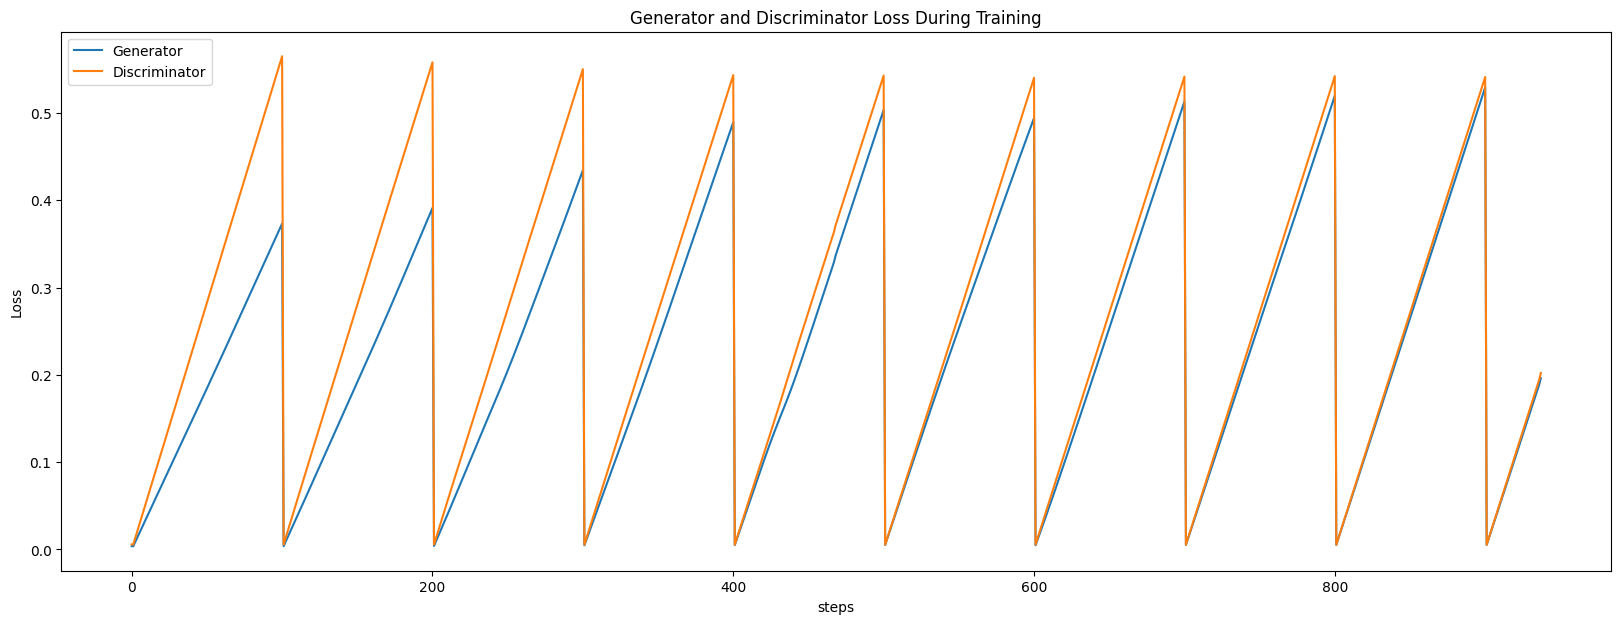

In [20]:
plt.figure(figsize=(20, 7))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, label="Generator")
plt.plot(discriminator_losses, label="Discriminator")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

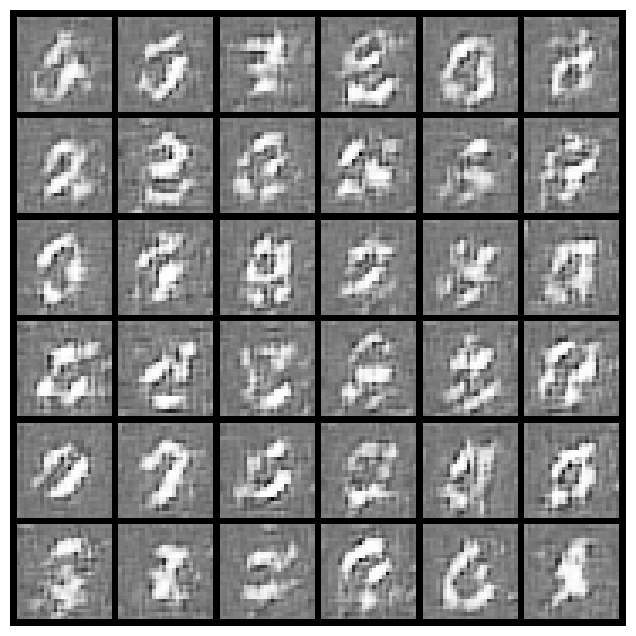

In [21]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
imgs = [[plt.imshow(np.transpose(img, (1,2,0)), animated=True)] for img in image_show]
anim = animation.ArtistAnimation(fig, imgs, interval=100, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())